In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.finetuner import LSTMChemFinetuner
from lstm_chem.data_loader import DataLoader

In [2]:
config = process_config('experiments/2019-12-23/LSTM_Chem/config.json')

modeler = LSTMChem(config, session='finetune')
finetune_dl = DataLoader(config, data_type='finetune')

finetuner = LSTMChemFinetuner(modeler, finetune_dl)
finetuner.finetune()

Loading model architecture from experiments/2019-12-23/LSTM_Chem/model_arch.json ...


100%|██████████| 5/5 [00:00<00:00, 734.32it/s]

Loading model checkpoint from experiments/2019-12-23/LSTM_Chem/checkpoints/LSTM_Chem-22-0.47.hdf5 ...
Loaded the Model.
loading SMILES...
done.
tokenizing SMILES...
done.
Epoch 1/12


5/5 [==============================] - 3s 511ms/step - loss: 0.9790
Epoch 2/12
5/5 [==============================] - 3s 540ms/step - loss: 1.0440
Epoch 3/12
5/5 [==============================] - 2s 436ms/step - loss: 0.9044
Epoch 4/12
5/5 [==============================] - 2s 414ms/step - loss: 0.6483
Epoch 5/12
5/5 [==============================] - 3s 501ms/step - loss: 1.0154
Epoch 6/12
5/5 [==============================] - 3s 565ms/step - loss: 0.7550
Epoch 7/12
5/5 [==============================] - 2s 414ms/step - loss: 0.4813
Epoch 8/12
5/5 [==============================] - 3s 551ms/step - loss: 0.3598
Epoch 9/12
5/5 [==============================] - 3s 560ms/step - loss: 0.3779
Epoch 10/12
5/5 [==============================] - 2s 496ms/step - loss: 0.4680
Epoch 11/12
5/5 [==============================] - 2s 481ms/step - loss: 0.4630
Epoch 12/12
5/5 [==============================] - 2s 449ms/step - loss: 0.2421


In [3]:
finetuned_smiles = finetuner.sample(num=100)

In [4]:
with open('./datasets/known_TRPM8-inhibitors_cleansed.smi') as f:
    ksmiles = [l.rstrip() for l in f]
kmols = [Chem.MolFromSmiles(smi) for smi in ksmiles]

Kfps = []
for mol in kmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Kfps.append(fp)

Klen = len(Kfps)

In [5]:
with open('./datasets/TRPM8_inhibitors_for_fine-tune.smi') as f:
    fsmiles = [l.rstrip() for l in f]
fmols = [Chem.MolFromSmiles(smi) for smi in fsmiles]

Ffps, Fbvs = [], []
for mol in fmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Fbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ffps.append(fp)

Flen = len(Ffps)

In [6]:
Sfps, Sbvs, smols = [], [], []
for smi in finetuned_smiles:
    mol = Chem.MolFromSmiles(smi)
    smols.append(mol)
    
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Sbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Sfps.append(fp)

In [7]:
x = Kfps + Ffps + Sfps
pca = PCA(n_components=2, random_state=71)
X = pca.fit_transform(x)

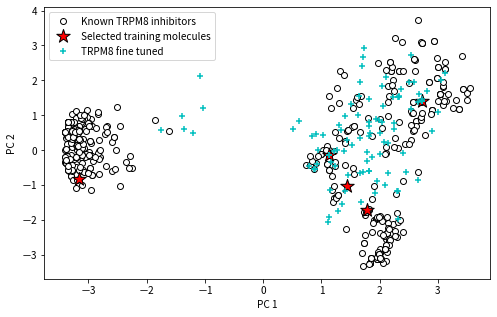

In [8]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:Klen, 0], X[:Klen, 1],
            c='w', edgecolors='k', label='Known TRPM8 inhibitors')
plt.scatter(X[Klen:Klen + Flen, 0], X[Klen:Klen + Flen, 1],
            s=200, c='r', marker='*', edgecolors='k', label='Selected training molecules')
plt.scatter(X[Klen + Flen:, 0], X[Klen + Flen:, 1],
            c='c', marker='+', label='TRPM8 fine tuned')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

In [9]:
idxs = []
for Fbv in Fbvs:
    idx = np.argmax(DataStructs.BulkTanimotoSimilarity(Fbv, Sbvs))
    idxs.append(idx)
nsmols = [smols[idx] for idx in idxs]

In [10]:
showmols = []
for i, j in zip(fmols, nsmols):
    showmols.append(i)
    showmols.append(j)

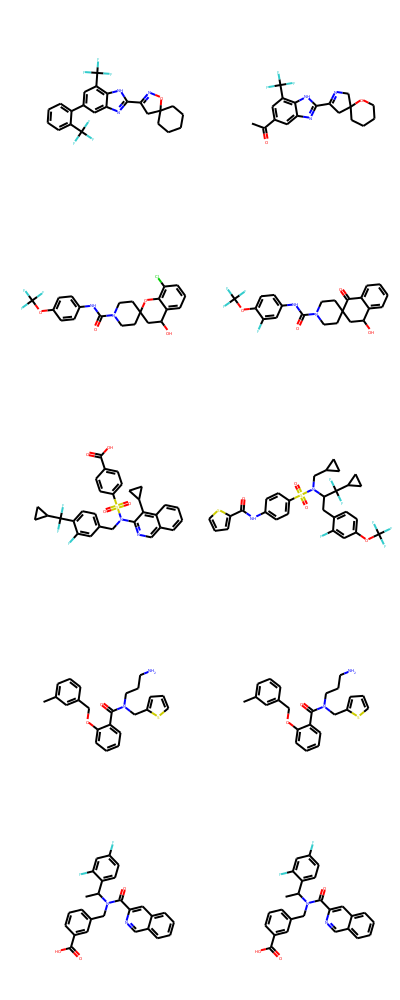

In [11]:
Draw.MolsToGridImage(showmols, molsPerRow=2)